In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
import tempfile
import os
import shutil
from copy import deepcopy
import cartopy.crs as ccrs
import shapely
import pyart
from tint.data_utils import get_nexrad_keys, read_nexrad_key
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif
import pandas as pd


# from lmatools.io.LMA_h5_file import LMAh5File
# from lmatools.coordinateSystems import RadarCoordinateSystem, GeographicSystem, TangentPlaneCartesianSystem, MapProjection


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/pydap/model.py:175: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import OrderedDict, Mapping
/Users/kelcy/opt/anaconda3/envs/TTU_KNB/lib/python3.8/site-packages/pydap/responses/das.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [2]:
#### - dualpol

def radar_coords_to_cart(rng, az, ele, debug=False):
    """
    TJL - taken from old Py-ART version
    Calculate Cartesian coordinate from radar coordinates
    Parameters
    ----------
    rng : array
        Distances to the center of the radar gates (bins) in kilometers.
    az : array
        Azimuth angle of the radar in degrees.
    ele : array
        Elevation angle of the radar in degrees.
    Returns
    -------
    x, y, z : array
        Cartesian coordinates in meters from the radar.
    Notes
    -----
    The calculation for Cartesian coordinate is adapted from equations
    2.28(b) and 2.28(c) of Doviak and Zrnic [1]_ assuming a
    standard atmosphere (4/3 Earth's radius model).
    .. math::
        z = \\sqrt{r^2+R^2+r*R*sin(\\theta_e)} - R
        s = R * arcsin(\\frac{r*cos(\\theta_e)}{R+z})
        x = s * sin(\\theta_a)
        y = s * cos(\\theta_a)
    Where r is the distance from the radar to the center of the gate,
    :math:`\\theta_a` is the azimuth angle, :math:`\\theta_e` is the
    elevation angle, s is the arc length, and R is the effective radius
    of the earth, taken to be 4/3 the mean radius of earth (6371 km).
    References
    ----------
    .. [1] Doviak and Zrnic, Doppler Radar and Weather Observations, Second
        Edition, 1993, p. 21.
    """
    theta_e = ele * np.pi / 180.0       # elevation angle in radians.
    theta_a = az * np.pi / 180.0        # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0     # effective radius of earth in meters.
    r = rng * 1000.0                    # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z

####

"""
This is the main source code for DualPol.
Key classes:
- DualPolRetrieval
- HidColors
- _FhcVars
Key functions:
- get_xyz_from_radar
- check_kwargs
"""

from __future__ import print_function
import numpy as np
import warnings
import time as tt
import pyart
import matplotlib.colors as colors
# from .common import radar_coords_to_cart
# from skewt import SkewT
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain,
                            csu_dsd, csu_kdp, csu_misc)

VERSION = '1.0.2'
RNG_MULT = 1000.0
DEFAULT_WEIGHTS = csu_fhc.DEFAULT_WEIGHTS
BAD = -32768
DEFAULT_SDP = 12.0
DEFAULT_DZ_RANGE = csu_misc.DEFAULT_DZ_RANGE
DEFAULT_DZ_THRESH = 38.0
DEFAULT_KD_THRESH = 0.3
DEFAULT_DR_THRESH = csu_misc.DEFAULT_DR_THRESH

#####################################

DEFAULT_KW = {'dz': 'DZ', 'dr': 'DR', 'dp': None, 'rh': 'RH',
              'kd': None, 'ld': None, 'sounding': None,
              'verbose': False, 'thresh_sdp': DEFAULT_SDP, 'fhc_T_factor': 1,
              'fhc_weights': DEFAULT_WEIGHTS, 'name_fhc': 'FH', 'band': 'S',
              'fhc_method': 'hybrid', 'kdp_method': 'CSU', 'bad': BAD,
              'use_temp': True, 'ice_flag': False, 'dsd_flag': True,
              'fhc_flag': True, 'rain_method': 'hidro', 'precip_flag': True,
              'liquid_ice_flag': True, 'winter': False, 'gs': 150.0,
              'qc_flag': False, 'kdp_window': 3.0, 'std_gate': 11,
              'dz_range': DEFAULT_DZ_RANGE, 'name_sdp': 'SDP_CSU',
              'thresh_dr': DEFAULT_DR_THRESH, 'speckle': 4,
              'thresh_dz': DEFAULT_DZ_THRESH, 'thresh_kd': DEFAULT_KD_THRESH,
              'r_kdp_a': 40.5, 'r_kdp_b': 0.85, 'r_z_a': 300.0,
              'r_z_b': 1.4, 'r_z_zdr_a': 6.7e-3, 'r_z_zdr_b': 0.927,
              'r_z_zdr_c': -0.343, 'r_kdp_zdr_a': 90.8, 'r_kdp_zdr_b': 0.93,
              'r_kdp_zdr_c': -0.169, 'thresh_zdr': 0.5}

kwargs = np.copy(DEFAULT_KW)

#####################################


class DualPolRetrieval(object):

    """
    Class that wraps all the dual-polarization retrievals powered by
    CSU_RadarTools.
    Brief overview of DualPolRetrieval structure
    --------------------------------------------
    Main attributes of interest is radar, which is the original Py-ART radar
    object provided to DualPolRetrieval. DualPolRetrieval.radar contains
    new fields based on what the user wanted DualPolRetrieval to do.
    New fields that can be in DualPolRetrieval.radar.fields:
    'FH' (or whatever user provided in name_fhc kwarg) = HID
    'FI' = Ice Fraction
    'ZDP' = Difference Reflectivity
    'KDP_CSU' = KDP as calculated by CSU_RadarTools
    'FDP_CSU' = Filtered differential phase
    'SDP_CSU' = Standard deviation of differential phase
    'MI' = Mass of ice
    'MW' = Mass of liquid water
    'rain' = Rainfall rate
    'method' = Rainfall method used
    'D0' = Median Volume Diameter
    'NW' = Normalized Intercept Parameter
    'MU' = Mu in Gamma DSD model
    """

    def __init__(self, radar, **kwargs):
        """
        Arguments
        ---------
        radar = Py-ART radar object
        Keywords
        --------
        dz = String name of reflectivity field
        dr = String name of differential reflectivity field
        kd = String name of specific differential phase field, if not provided
             it will be calculated using csu_radartools
        rh = String name of correlation coefficient field
        ld = String name of linear depolarization ratio field
        dp = String name of differential phase field
        sounding = Name of UWYO sounding file or 2xN array where:
                   sounding['z'] = Heights (m MSL), must be montonic
                   sounding['T'] = Temperatures (C)
        winter = Flag to note whether to use wintertime retrievals
        band = Radar frequency band letter ('C' or 'S' supported)
        verbose = Set to True to get text feedback
        thresh_sdp = Threshold on standard deviation of differential phase to
                     use on KDP calculation (if done)
        fhc_T_factor = Extra weighting on T to be used in HID calculations
        fhc_weights = Weights for variables in HID. Dictionary form, like so:
            {'DZ': 1.5, 'DR': 0.8, 'KD': 1.0, 'RH': 0.8, 'LD': 0.5, 'T': 0.4}
        name_fhc = Name to give HID field once calculated
        fhc_method = 'hybrid' or 'linear' methods; hybrid preferred
        kdp_method = 'CSU' currently supported
        bad = Value to provide bad data
        use_temp = Set to False to not consider T in HID calculations
        rain_method = Method to use to estimate rainfall. If not 'hidro', then
                      will use blended rainfall algorithm based on ZDP & ice
                      fraction. If 'hidro', then uses CSU_HIDRO approach.
        ice_flag = Set to True to return ice fraction and ZDP from CSU blended
                   rainfall algorithm and store them as radar object fields.
                   Only used if rain_method is not 'hidro'.
        dsd_flag = Set to False to not calculate DSD parameters
        fhc_flag = Set to False to not calculate HID
        precip_flag = Set to False to not calculate rainfall
        liquid_ice_flag = Set to False to not calculate liquid/ice mass
        gs = Gate spacing of the radar (meters). Only used if KDP is calculated
             using CSU_RadarTools.
        kdp_window = Window length (in km) used as basis for PHIDP filtering.
                     Only used if KDP is calculated using CSU_RadarTools.
        name_sdp = Name of field holding (or that will hold) the SDP data.
        qc_flag = Set to true to filter the data for insects, high SDP
                  (set by thresh_sdp keyword), and speckles. Will permanently
                  change the reflectivity field's mask, and by extension affect
                  all retrieved fields' masks.
        dz_range = Used by the insect filter. A list of 2-element tuples.
                   Within each DZ range represented by a tuple, the ZDR
                   threshold in dr_thresh (see below) will be applied.
        thresh_dr = List of thresholds on ZDR to be applied within a given
                    element of dz_range (see above).
        speckle = Number of contiguous gates or less for an element to be
                  considered a speckle.
        std_gate = Number of gates for standard deviation of phase calculation.
                   Must be odd or csu_kdp will set it to the default value.
        thresh_dz = Value of Z that determines logical breakpoints in blended
                    rainfall calculations.
        thresh_kd = Value of Kdp that determines logical breakpoints in blended
                    rainfall calculations.
        thresh_zdr = Value of Zdr that determines logical breaks in blended
                     rainfall calculations.
        r_z_a, r_z_b => Z = a * R**b
        r_kdp_a, r_kdp_b => R = a * kdp**b
        r_kdp_zdr_a, r_kdp_zdr_b, r_kdp_zdr_c => R = a*kdp**b*10.0**(c*zdr)
        r_z_zdr_a,r_z_zdr_b,r_z_zdr_c => R = a*linearize(z)**b*10.0**(c*zdr)
        """
        # Set radar fields
        kwargs = check_kwargs(kwargs, DEFAULT_KW)
        self.verbose = kwargs['verbose']
        flag = self.do_radar_check(radar)
        if not flag:
            return
        self._populate_attributes(kwargs)
        flag = self.do_name_check()
        if not flag:
            return

        # Get sounding info
        self.T_flag = kwargs['use_temp']
        self.T_factor = kwargs['fhc_T_factor']
        self.get_sounding(kwargs['sounding'])
        self.winter_flag = kwargs['winter']

        # Do QC
        if kwargs['qc_flag']:
            if self.verbose:
                print('Performing QC')
            self.dz_range = kwargs['dz_range']
            self.dr_thresh = kwargs['thresh_dr']
            self.speckle = kwargs['speckle']
            self.do_qc()

        # Do FHC
        self.band = kwargs['band']
        self.name_fhc = kwargs['name_fhc']
        if kwargs['fhc_flag']:
            if self.verbose:
                print('Performing FHC')
            self.fhc_weights = kwargs['fhc_weights']
            self.fhc_method = kwargs['fhc_method']
            self.get_hid()

        # Other precip retrievals
        if kwargs['precip_flag']:
            if self.verbose:
                print('Performing precip rate calculations')
            for key in ['r_kdp_a', 'r_kdp_b', 'r_z_a', 'r_z_b',
                        'r_z_zdr_a', 'r_z_zdr_b', 'r_z_zdr_c',
                        'r_kdp_zdr_a', 'r_kdp_zdr_b', 'r_kdp_zdr_c']:
                setattr(self, key, kwargs[key])
            self.get_precip_rate(
                ice_flag=kwargs['ice_flag'], rain_method=kwargs['rain_method'],
                thresh_dz=kwargs['thresh_dz'], thresh_kd=kwargs['thresh_kd'],
                thresh_zdr=kwargs['thresh_zdr'])
        if kwargs['dsd_flag']:
            if self.verbose:
                print('Performing DSD calculations')
            self.get_dsd()
        if kwargs['liquid_ice_flag']:
            if self.verbose:
                print('Performing mass calculations')
            self.get_liquid_and_frozen_mass()

    def do_radar_check(self, radar):
        """
        Checks to see if radar variable is a file or a Py-ART radar object.
        """
        if isinstance(radar, str):
            try:
                self.radar = pyart.io.read(radar)
            except:
                warnings.warn('Bad file name provided, try again')
                return False
        else:
            self.radar = radar
        # Checking for actual radar object
        try:
            junk = self.radar.latitude['data']
        except:
            warnings.warn('Need a real Py-ART radar object, try again')
            return False
        return True  # Actual radar object provided by user

    def do_name_check(self):
        """
        Simple name checking to ensure the file actually contains the
        right polarimetric variables.
        """
        wstr = ' field not in radar object, check variable names'
        if self.name_dz in self.radar.fields:
            if self.name_dr in self.radar.fields:
                if self.name_rh in self.radar.fields:
                    if self.name_ld is not None:
                        if self.name_ld not in self.radar.fields:
                            if self.verbose:
                                print('Not finding LDR field, not using')
                            self.name_ld = None
                    else:
                        if self.verbose:
                            print('Not provided LDR field, not using')
                    if self.name_kd is not None:
                        if self.name_kd not in self.radar.fields:
                            if self.verbose:
                                print('Not finding KDP field, calculating')
                            kdp_flag = self.calculate_kdp()
                        else:
                            kdp_flag = True
                    else:
                        if self.verbose:
                            print('Not provided KDP field, calculating')
                        kdp_flag = self.calculate_kdp()
                    return kdp_flag  # All required variables present?
                else:
                    warnings.warn(self.name_rh+wstr)
                    return False
            else:
                warnings.warn(self.name_dr+wstr)
                return False
        else:
            warnings.warn(self.name_dz+wstr)
            return False

    def calculate_kdp(self):
        """
        Wrapper method for calculating KDP.
        """
        wstr = 'Missing differential phase and KDP fields, failing ...'
        if self.name_dp is not None:
            if self.name_dp in self.radar.fields:
                if self.kdp_method.upper() == 'CSU':
                    kdp = self.call_csu_kdp()
                self.name_kd = 'KDP_' + self.kdp_method
                self.add_field_to_radar_object(
                    kdp, standard_name='KDP',
                    field_name=self.name_kd, units='deg km-1',
                    long_name='Specific Differential Phase')
            else:
                warnings.warn(wstr)
                return False
        else:
            warnings.warn(wstr)
            return False
        return True

    def call_csu_kdp(self):
        """
        Calls the csu_radartools.csu_kdp module to obtain KDP, FDP, and SDP.
        """
        if self.verbose:
            print('Calculating KDP via CSU method')
        dp = self.extract_unmasked_data(self.name_dp)
        dz = self.extract_unmasked_data(self.name_dz)
        kdp = np.zeros_like(dp) + self.bad
        fdp = kdp * 1.0
        sdp = kdp * 1.0
        rng = self.radar.range['data'] / RNG_MULT
        az = self.radar.azimuth['data']
        rng2d, az2d = np.meshgrid(rng, az)
#        print('debug calling csu_kdp')
        bt = tt.time()
        kdp, fdp, sdp = \
            csu_kdp.calc_kdp_bringi(dp=dp, dz=dz, rng=rng2d, gs=self.gs,
                                    thsd=self.thresh_sdp, bad=self.bad,
                                    window=self.kdp_window,
                                    std_gate=self.std_gate)
        print(tt.time()-bt, 'seconds to run csu_kdp')
#        print('debug dualpol kdp', np.shape(kdp))
        self.name_fdp = 'FDP_' + self.kdp_method
        self.add_field_to_radar_object(
            fdp, units='deg', standard_name='Filtered Differential Phase',
            field_name=self.name_fdp,
            long_name='Filtered Differential Phase')
        self.add_field_to_radar_object(
            sdp, units='deg', standard_name='Std Dev Differential Phase',
            field_name=self.name_sdp,
            long_name='Standard Deviation of Differential Phase')
        return kdp

    def extract_unmasked_data(self, field, bad=None):
        """Extracts an unmasked field from the radar object."""
        var = self.radar.fields[field]['data']
        if hasattr(var, 'mask'):
            if bad is None:
                bad = self.bad
            var = var.filled(fill_value=bad)
        return var

    def get_sounding(self, sounding):
        """
        Ingests the sounding (either a skewt - i.e., UWYO - formatted file
        or a properly formatted dict).
        """
        if sounding is None:
            print('No sounding provided')
            self.T_flag = False
        else:
            if isinstance(sounding, str):
                # Removing exception handling so if SkewT is messing up
                # the end user will understand better how to fix it.
                if True:
#                     snd = SkewT.Sounding(sounding)
                    # Test for new version of skewt package
                    if hasattr(snd, 'soundingdata'):
                        self.snd_T = snd.soundingdata['temp']
                        self.snd_z = snd.soundingdata['hght']
                    else:
                        self.snd_T = snd.data['temp']
                        self.snd_z = snd.data['hght']
                else:
                    print('Sounding read fail')
                    self.T_flag = False
            else:
                try:
                    self.snd_T = sounding['T']
                    self.snd_z = sounding['z']
                except:
                    print('Sounding in wrong data format')
                    self.T_flag = False
        self.interpolate_sounding_to_radar()

    def do_qc(self):
        if self.name_sdp not in self.radar.fields:
            print('Cannot do QC, no SDP field identified')
            return
        if self.verbose:
            print('Masking insects and high SDP,', end=' ')
        dz = self.extract_unmasked_data(self.name_dz)
        dr = self.extract_unmasked_data(self.name_dr)
        sdp = self.extract_unmasked_data(self.name_sdp)
        dp = self.extract_unmasked_data(self.name_dp)
        dz_mask = dz == self.bad
        insect_mask = csu_misc.insect_filter(
            dz, dr, dz_range=self.dz_range, dr_thresh=self.dr_thresh,
            bad=self.bad, mask=dz_mask)
        sdp_mask = csu_misc.differential_phase_filter(
            sdp, thresh_sdp=self.thresh_sdp)
        dp_cond = dp != self.bad
        sdp_mask = np.logical_and(sdp_mask, dp_cond)
        new_mask = np.logical_or(insect_mask, sdp_mask)
        dz_qc = 1.0 * dz
        dz_qc[new_mask] = self.bad
        if self.verbose:
            print('Despeckling')
        mask_ds = csu_misc.despeckle(dz_qc, bad=self.bad, ngates=self.speckle)
        final_mask = np.logical_or(new_mask, mask_ds)
        setattr(self.radar.fields[self.name_dz]['data'], 'mask', final_mask)

    def get_hid(self):
        """Calculate hydrometeror ID, add to radar object."""
        _fhv = _FhcVars(self)
        if not self.winter_flag:
            bt = tt.time()
            # Cut down on processing missing/bad data
            good = _fhv.dz != self.bad
            if self.name_ld is not None:
                _fhv.ld = _fhv.ld[good]
            if _fhv.tt is not None:
                _fhv.tt = _fhv.tt[good]
            # Only run FHC if the scope is not completely blank
            if np.size(_fhv.dz[good]) > 0:
                scores = csu_fhc.csu_fhc_summer(
                    dz=_fhv.dz[good], zdr=_fhv.dr[good], rho=_fhv.rh[good],
                    kdp=_fhv.kd[good], ldr=_fhv.ld, use_temp=self.T_flag,
                    band=self.band, method=self.fhc_method, T=_fhv.tt,
                    verbose=self.verbose, temp_factor=self.T_factor,
                    weights=self.fhc_weights)
                # Create and populate the FHC field
                fh = np.zeros_like(_fhv.dz) + self.bad
                fh[good] = np.argmax(scores, axis=0) + 1
                fh = np.reshape(fh, _fhv.shp)
                self.add_field_to_radar_object(fh, field_name=self.name_fhc)
                print(tt.time()-bt, 'seconds to do FHC')
            else:
                print('No good data for FHC, not performed')
        else:
            print('Winter HID not enabled yet, sorry!')

    def get_precip_rate(
            self, ice_flag=False, rain_method='hidro', thresh_zdr=0.5,
            thresh_dz=DEFAULT_DZ_THRESH, thresh_kd=DEFAULT_KD_THRESH):
        """Calculate rain rate, add to radar object."""
        dz = self.radar.fields[self.name_dz]['data']
        dr = self.radar.fields[self.name_dr]['data']
        kd = self.radar.fields[self.name_kd]['data']
        if not self.winter_flag:
            if rain_method == 'hidro':
                fhc = self.radar.fields[self.name_fhc]['data']
                rain, method = csu_blended_rain.csu_hidro_rain(
                    dz=dz, zdr=dr, kdp=kd, fhc=fhc, band=self.band,
                    thresh_dz=thresh_dz, thresh_kdp=thresh_kd,
                    thresh_zdr=thresh_zdr, r_z_a=self.r_z_a, r_z_b=self.r_z_b,
                    r_kdp_a=self.r_kdp_a, r_kdp_b=self.r_kdp_b,
                    r_z_zdr_a=self.r_z_zdr_a, r_z_zdr_b=self.r_z_zdr_b,
                    r_z_zdr_c=self.r_z_zdr_c, r_kdp_zdr_a=self.r_kdp_zdr_a,
                    r_kdp_zdr_b=self.r_kdp_zdr_b, r_kdp_zdr_c=self.r_kdp_zdr_c)
            else:
                if not ice_flag:
                    rain, method = csu_blended_rain.calc_blended_rain(
                        dz=dz, zdr=dr, kdp=kd, band=self.band,
                        thresh_dz=thresh_dz, thresh_kdp=thresh_kd,
                        thresh_zdr=thresh_zdr, r_z_a=self.r_z_a,
                        r_z_b=self.r_z_b, r_kdp_a=self.r_kdp_a,
                        r_kdp_b=self.r_kdp_b, r_z_zdr_a=self.r_z_zdr_a,
                        r_z_zdr_b=self.r_z_zdr_b, r_z_zdr_c=self.r_z_zdr_c,
                        r_kdp_zdr_a=self.r_kdp_zdr_a,
                        r_kdp_zdr_b=self.r_kdp_zdr_b,
                        r_kdp_zdr_c=self.r_kdp_zdr_c)
                else:
                    rain, method, zdp, fi = csu_blended_rain.calc_blended_rain(
                        dz=dz, zdr=dr, kdp=kd, ice_flag=ice_flag,
                        band=self.band, thresh_dz=thresh_dz,
                        thresh_kdp=thresh_kd, thresh_zdr=thresh_zdr,
                        r_z_a=self.r_z_a, r_z_b=self.r_z_b,
                        r_kdp_a=self.r_kdp_a, r_kdp_b=self.r_kdp_b,
                        r_z_zdr_a=self.r_z_zdr_a,
                        r_z_zdr_b=self.r_z_zdr_b, r_z_zdr_c=self.r_z_zdr_c,
                        r_kdp_zdr_a=self.r_kdp_zdr_a,
                        r_kdp_zdr_b=self.r_kdp_zdr_b,
                        r_kdp_zdr_c=self.r_kdp_zdr_c)
                    self.add_field_to_radar_object(
                        zdp, field_name='ZDP', units='dB',
                        long_name='Difference Reflectivity',
                        standard_name='Difference Reflectivity')
                    self.add_field_to_radar_object(
                        fi, field_name='FI', units='',
                        long_name='Ice Fraction', standard_name='Ice Fraction')
        else:
            print('Winter precip not enabled yet, sorry!')
            return
        self.add_field_to_radar_object(rain, field_name='rain', units='mm h-1',
                                       long_name='Rainfall Rate',
                                       standard_name='Rainfall Rate')
        self.add_field_to_radar_object(method, field_name='method', units='',
                                       long_name='Rainfall Method',
                                       standard_name='Rainfall Method')

    def get_dsd(self):
        """Calculate DSD information, add to radar object."""
        dz = self.radar.fields[self.name_dz]['data']
        dr = self.radar.fields[self.name_dr]['data']
        kd = self.radar.fields[self.name_kd]['data']
        d0, Nw, mu = csu_dsd.calc_dsd(dz=dz, zdr=dr, kdp=kd, band=self.band,
                                      method='2009')
        self.add_field_to_radar_object(d0, field_name='D0', units='mm',
                                       long_name='Median Volume Diameter',
                                       standard_name='Median Volume Diameter')
        self.add_field_to_radar_object(
            Nw, field_name='NW', units='mm-1 m-3',
            long_name='Normalized Intercept Parameter',
            standard_name='Normalized Intercept Parameter')
        self.add_field_to_radar_object(mu, field_name='MU', units=' ',
                                       long_name='Mu', standard_name='Mu')

    def get_liquid_and_frozen_mass(self):
        """Calculate liquid/ice mass, add to radar object."""
        mw, mi = csu_liquid_ice_mass.calc_liquid_ice_mass(
                         self.radar.fields[self.name_dz]['data'],
                         self.radar.fields[self.name_dr]['data'],
                         self.radar_z/1000.0, T=self.radar_T)
        self.add_field_to_radar_object(mw, field_name='MW', units='g m-3',
                                       long_name='Liquid Water Mass',
                                       standard_name='Liquid Water Mass')
        self.add_field_to_radar_object(mi, field_name='MI', units='g m-3',
                                       long_name='Ice Water Mass',
                                       standard_name='Ice Water Mass')

    def add_field_to_radar_object(self, field, field_name='FH',
                                  units='unitless', long_name='Hydrometeor ID',
                                  standard_name='Hydrometeor ID'):
        """
        Adds a newly created field to the Py-ART radar object.
        """
        masked_field = np.ma.asanyarray(field)
        masked_field.mask = masked_field == self.bad
        if hasattr(self.radar.fields[self.name_dz]['data'], 'mask'):
            masked_field.mask = np.logical_or(
                masked_field.mask,
                self.radar.fields[self.name_dz]['data'].mask)
            try:
                fill_value = self.radar.fields[self.name_dz]['_FillValue']
            except KeyError:
                fill_value = self.bad
        field_dict = {'data': masked_field,
                      'units': units,
                      'long_name': long_name,
                      'standard_name': standard_name,
                      '_FillValue': fill_value}
        self.radar.add_field(field_name, field_dict, replace_existing=True)

    def interpolate_sounding_to_radar(self):
        """Takes sounding data and interpolates it to every radar gate."""
        xx, yy, self.radar_z = get_xyz_from_radar(self.radar)
        self.radar_T = None
        self.check_sounding_for_montonic()
        if self.T_flag:
            shape = np.shape(self.radar_z)
            rad_z1d = self.radar_z.ravel()
            rad_T1d = np.interp(rad_z1d, self.snd_z, self.snd_T)
            if self.verbose:
                print('Trying to get radar_T')
            self.radar_T = np.reshape(rad_T1d, shape)
            self.add_field_to_radar_object(
                self.radar_T, field_name='temperature', units='deg C',
                long_name='Temperature', standard_name='Temperature')

    def check_sounding_for_montonic(self):
        """
        So sounding interpolation doesn't fail, force the sounding to behave
        monotonically so that z always increases. This eliminates data from
        descending balloons.
        """
        dummy_z = []
        dummy_T = []
        if hasattr(self, 'snd_T'):
            if not self.snd_T.mask[0]:  # May cause issue for some soundings
                dummy_z.append(self.snd_z[0])
                dummy_T.append(self.snd_T[0])
            for i, height in enumerate(self.snd_z):
                if i > 0:
                    if self.snd_z[i] > self.snd_z[i-1] and not\
                       self.snd_T.mask[i]:
                        dummy_z.append(self.snd_z[i])
                        dummy_T.append(self.snd_T[i])
            self.snd_z = np.array(dummy_z)
            self.snd_T = np.array(dummy_T)

    def _populate_attributes(self, kwargs):
        """
        This internal method declutters self.__init__()
        """
        self.name_dz = kwargs['dz']
        self.name_dr = kwargs['dr']
        self.name_kd = kwargs['kd']
        self.name_rh = kwargs['rh']
        self.name_ld = kwargs['ld']
        self.name_dp = kwargs['dp']
        self.kdp_method = kwargs['kdp_method']
        self.bad = kwargs['bad']
        self.thresh_sdp = kwargs['thresh_sdp']
        self.gs = kwargs['gs']
        self.name_sdp = kwargs['name_sdp']
        self.kdp_window = kwargs['kdp_window']
        self.std_gate = kwargs['std_gate']

################################


class _FhcVars(object):

    """
    Internal class for parsing and prepping the radar variables for FHC.
    """

    def __init__(self, dpret):
        """
        dpret = DualPolRetrieval object
        """
        self.grab_vars(dpret)

    def grab_vars(self, dpret):
        """
        Added try statements in case fields are not masked arrays
        """
        try:
            self.dz = dpret.radar.fields[dpret.name_dz]['data'].filled(
                fill_value=dpret.bad)
        except AttributeError:
            self.dz = dpret.radar.fields[dpret.name_dz]['data']
        self.shp = np.shape(self.dz)
        self.dz = self.dz.flatten()
        try:
            self.dr = dpret.radar.fields[dpret.name_dr]['data'].filled(
                fill_value=dpret.bad).flatten()
        except AttributeError:
            self.dr = dpret.radar.fields[dpret.name_dr]['data'].flatten()
        try:
            self.kd = dpret.radar.fields[dpret.name_kd]['data'].filled(
                fill_value=dpret.bad).flatten()
        except:
            self.kd = dpret.radar.fields[dpret.name_kd]['data'].flatten()
        try:
            self.rh = dpret.radar.fields[dpret.name_rh]['data'].filled(
                fill_value=dpret.bad).flatten()
        except:
            self.rh = dpret.radar.fields[dpret.name_rh]['data'].flatten()
        # LDR is optional
        if dpret.name_ld is not None:
            try:
                self.ld = dpret.radar.fields[dpret.name_ld]['data'].filled(
                    fill_value=dpret.bad).flatten()
            except AttributeError:
                self.ld = dpret.radar.fields[dpret.name_ld]['data'].flatten()
        else:
            self.ld = None
        # Temperature is optional
        if dpret.radar_T is not None:
            self.tt = dpret.radar_T.flatten()
        else:
            self.tt = None

################################


class HidColors(object):

    """
    Class to help with colormaps/bars when plotting
    hydrometeor ID and rainfall method data with Py-ART.
    Sample interface
    ----------------
    radar = pyart.io.read(filename)
    retrieve = dualpol.DualPolRetrieval(radar, **kwargs)
    hidcolor = dualpol.HidColors()
    display = pyart.graph.RadarDisplay(retrieve.radar)
    display.plot_ppi('FH', vmin=0, vmax=10, cmap=hidcolor.cmaphid)
    display.cbs[0] = hidcolor.adjust_fhc_colorbar_for_pyart(display.cbs[0])
    """

    def __init__(self, winter=False):
        if not winter:
            self.hid_colors = ['White', 'LightBlue', 'MediumBlue',
                               'DarkOrange', 'LightPink', 'Cyan', 'DarkGray',
                               'Lime', 'Yellow', 'Red', 'Fuchsia']
            self.cmapmeth = colors.ListedColormap(self.hid_colors[0:6])
        self.cmaphid = colors.ListedColormap(self.hid_colors)

    def adjust_fhc_colorbar_for_pyart(self, cb):
        """Mods to make a hydrometeor ID colorbar"""
        cb.set_ticks(np.arange(1.4, 10, 0.9))
        cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Crystal', 'Aggregate',
                               'Wet Snow', 'Vert Ice', 'LD Graup',
                               'HD Graup', 'Hail', 'Big Drop'])
        cb.ax.set_ylabel('')
        cb.ax.tick_params(length=0)
        return cb

    def adjust_meth_colorbar_for_pyart(self, cb):
        """Mods to make a rainfall method colorbar"""
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)',
                               'R(Zrain)'])
        cb.ax.set_ylabel('')
        cb.ax.tick_params(length=0)
        return cb

################################


def get_xyz_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/RNG_MULT, az_2d, el_2d)
    # Using median value for now to avoid error with broadcasting diff shapes
    return xx, yy, zz + np.median(radar.altitude['data'])


def check_kwargs(kwargs, default_kw):
    """
    Check user-provided kwargs against defaults, and if some defaults aren't
    provided by user make sure they are provided to the function regardless.
    """
    for key in default_kw:
        if key not in kwargs:
            kwargs[key] = default_kw[key]
    return kwargs

#####################################




In [3]:
from boto.s3.connection import S3Connection
from datetime import datetime, timedelta, date, time
def get_nexrad_keys(site, start=None, end=None):
    """
    Get generator of pyart radar objects for all nexrad data between two
    datetimes from Amazon S3.
    ----------
    site : string
        site code e.g. 'khgx'
    start : string
        datetime e.g. '20180101_000000'
    end : string
        same format as start

    """
    fmt = '%Y%m%d_%H%M%S'

    if start is None:
        start = datetime.utcnow() - timedelta(hours=1)
    else:
        start = datetime.strptime(start, fmt)
    if end is None:
        end = datetime.utcnow()
    else:
        end = datetime.strptime(end, fmt)
    if end < start:
        print('end datetime precedes start datetime')
        return

    site = site.upper()

    dates = []
    day_i = start
    while day_i < end:
        dates.append(day_i)
        day_i += timedelta(days=1)

    date_keys = [datetime.strftime(date, '%Y/%m/%d/' + site) for date in dates]

    conn = S3Connection(anon=True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    keys = [key for date_key in date_keys
            for key in list(bucket.list(date_key))
            if '.tar' not in str(key)]
#
#
    nkeys = []
    for i in np.arange(len(keys)):
        if str(keys[i])[-5:-1] != '_MDM':
            nkeys.append(keys[i])

    keys = nkeys
#
#
    if len(keys) == 0:
        print('Found 0 files.')
        return

    # Key ealier for keys before 'V06'
    if '.gz>' in str(keys[0]):
        key_fmt = site + '%Y%m%d_%H%M%S_V06.gz>'
        key_fmt_earlier = site + '%Y%m%d_%H%M%S.gz>'
    else:
        key_fmt = site + '%Y%m%d_%H%M%S_V06>'
        key_fmt_earlier = site + '%Y%m%d_%H%M%S>'
        key_fmt_pia = site + '%Y%m%d_%H%M%S_V06.001>'

    key_dts = []
    for key in keys:
        #if key == "noaa-nexrad-level2,2017/04/05/KHTX/KHTX20170405_120908_V06.001":
        #if key == "noaa-nexrad-level2,2016/04/30/KHTX/KHTX20160430_191437_V06.gz":
        #    continue
        #print(key)
        try:
            key_dts.append(datetime.strptime(str(key).split('/')[-1], key_fmt))
        except ValueError:
            key_dts.append(
                datetime.strptime(str(key).split('/')[-1], key_fmt_pia))
    key_dts = zip(keys, key_dts)
    keys = [key for key, dt in key_dts if dt > start and dt < end]
    print('Found', len(keys), 'keys.')
    return keys

In [6]:
keys = get_nexrad_keys('kgrk', start='20230622_000000', end='20230622_020000')

Found 23 keys.


In [7]:
for key in keys:
    fname = os.path.split(str(key))[1][:-1]
    print(fname)
    if os.path.isfile(fname) == True :
      pass
    if os.path.isfile(fname) == False :
      radar = read_nexrad_key(key)
    zc = deepcopy(radar.fields['reflectivity']['data'])    
    radar.add_field_like('reflectivity', 'ZC', zc, replace_existing=True)
    retrieve = DualPolRetrieval(radar, dz='ZC', dr='differential_reflectivity',dp='differential_phase', 
                                  rh='cross_correlation_ratio', 
                                  fhc_T_factor=2, kdp_window=5,ice_flag=True, 
                                  rain_method='hidro', qc_flag=True, gs=250.0, 
                                  verbose=True,thresh_sdp=20.0, speckle=3)
    pyart.io.write_cfradial(fname + '_proc.nc', radar)
    print(key)

KGRK20230622_000339_V06
Not provided LDR field, not using
Not provided KDP field, calculating
Calculating KDP via CSU method
1.810776948928833 seconds to run csu_kdp
No sounding provided
Performing QC
Masking insects and high SDP, Despeckling
Performing FHC
USING VARIABLES:  {'DZ': 1, 'DR': 1, 'KD': 1, 'RH': 1, 'LD': 0, 'T': 0}
-->get_mbf_sets_summer   10 Category Summer S-band HID
-->get_mbf_sets_summer  No Temperature used in HID
Using beta functions
Not using T in FHC
Using hybrid HID method. Pol vars weighted, Z and T (if used) are multiplied
weight_sum:  2.6
(10, 2834076)
mu max:  1.0
2.661986827850342 seconds to do FHC
Performing precip rate calculations
Performing DSD calculations
Performing mass calculations
<Key: noaa-nexrad-level2,2023/06/22/KGRK/KGRK20230622_000339_V06>
KGRK20230622_000848_V06
Not provided LDR field, not using
Not provided KDP field, calculating
Calculating KDP via CSU method
1.8099250793457031 seconds to run csu_kdp
No sounding provided
Performing QC
Maskin

Text(0.5, 1.0, '')

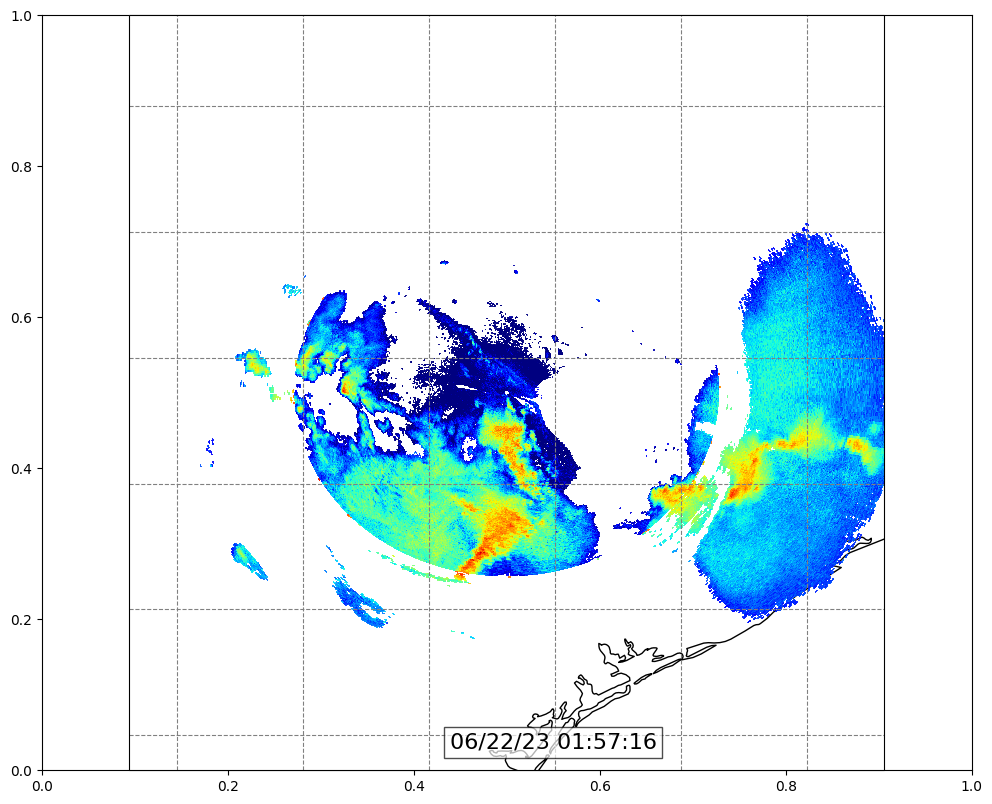

In [8]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12,10), dpi=100)
# fig = plt.figure(figsize=(5,5))#, dpi=100)

d = date(int(radar.time['units'][14:18]),int(radar.time['units'][19:21]),int(radar.time['units'][22:24]))
t = time(int(radar.time['units'][25:27]),int(radar.time['units'][28:30]),int(radar.time['units'][31:33]))
tt = datetime.combine(d,t)
elevations = radar.fixed_angle['data']

ax = fig.add_subplot(1,1,1, projection = projection)
ax.coastlines(resolution='10m')
ax.gridlines(color='gray', linestyle='--', draw_labels=False)

zoom = 3
ext = [ radar.longitude['data'][0] - zoom, radar.longitude['data'][0] + zoom, 
       radar.latitude['data'][0] - zoom, radar.latitude['data'][0] + zoom]
ax.set_extent(ext)

display = pyart.graph.RadarMapDisplay(radar)
# display.plot_ppi_map('reflectivity',sweep=0, vmin=10, vmax=65, ax=ax, fig=fig,mask_outside=True, 
#                      cmap='jet',colorbar_flag=False, embelish=False, alpha = 0.9)
display.plot_ppi_map('reflectivity',sweep=5, vmin=0, vmax=65, ax=ax, fig=fig,mask_outside=False, 
                     cmap='jet',colorbar_flag=False, embelish=False, alpha = 0.9)
#display.plot_colorbar(field = 'reflectivity')

td = fig.text(0.465, 0.147, tt.strftime("%m/%d/%y %H:%M:%S"),fontsize = 16,)
td.set_bbox(dict(facecolor='white', alpha=0.7))

# plt.setp( ax.get_xticklabels(), visible=False)
ax.set_title('')

# ax.text(-0.10, 0.55, 'Latitude (degree)', va='bottom', ha='center', rotation='vertical',rotation_mode='anchor',
#     transform=ax.transAxes, fontsize = 14)
# ax.text(0.5, -0.12, 'Longitude (degree)', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor',
#     transform=ax.transAxes, fontsize = 14)


In [10]:
def get_grid(radar):
    """ Returns grid object from radar object. """
    grid = pyart.map.grid_from_radars(
        radar, grid_shape=(31, 1001, 1001),
        grid_limits=((0, 15000), (-250000,250000), (-250000, 250000)),
        fields=['reflectivity', 'cross_correlation_ratio','differential_reflectivity', 'KDP_CSU','FH', 'D0', 'NW', 'MU', 'MW', 'MI'],
        gridding_algo='map_gates_to_grid',
        h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid

# def get_grid(radar):
#     """ Returns grid object from radar object. """
#     grid = pyart.map.grid_from_radars(
#         radar, grid_shape=(31, 1001, 1001),
#         grid_limits=((0, 15000), (-250000,250000), (-250000, 250000)),
#         fields=['CZ','DR','KD','RH','VR','W'],
#         gridding_algo='map_gates_to_grid',
#         h_factor=0., nb=0.6, bsp=1., min_radius=200.)
#     return grid

# def get_grid(radar):
#     """ Returns grid object from radar object. """
#     grid = pyart.map.grid_from_radars(
#         radar, grid_shape=(31, 401, 401),
#         grid_limits=((0, 15000), (-200000,200000), (-200000, 200000)),
#         fields=['reflectivity'], gridding_algo='map_gates_to_grid',
#         h_factor=0., nb=0.6, bsp=1., min_radius=200.)
#     return grid

In [12]:
import glob
arq = sorted(glob.glob('/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230*V06_proc.nc'))

radar = pyart.io.read_cfradial(arq[0])


In [13]:
arq

['/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_200029_V06_proc.nc',
 '/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_200330_V06_proc.nc',
 '/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_200631_V06_proc.nc',
 '/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_200945_V06_proc.nc',
 '/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_201259_V06_proc.nc',
 '/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_201613_V06_proc.nc',
 '/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_201926_V06_proc.nc',
 '/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_202253_V06_proc.nc',
 '/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_202607_V06_proc.nc',
 '/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_202921_V06_proc.nc',
 '/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD

In [14]:
filenames = []
for num, key in enumerate(arq):
    print(key)
    print('saving grid', num)
    radar = pyart.io.read_cfradial(key)
    grid = get_grid(radar)
    fname = os.path.split(str(key))[1][:-8]
    name = os.path.join(fname + '_grid.nc')
    pyart.io.write_grid(name, grid)
    del radar, grid

/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_200029_V06_proc.nc
saving grid 0
/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_200330_V06_proc.nc
saving grid 1
/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_200631_V06_proc.nc
saving grid 2
/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_200945_V06_proc.nc
saving grid 3
/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_201259_V06_proc.nc
saving grid 4
/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_201613_V06_proc.nc
saving grid 5
/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_201926_V06_proc.nc
saving grid 6
/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_202253_V06_proc.nc
saving grid 7
/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/KGRK20230621_202607_V06_proc.nc
saving grid 8
/Users/kelcy/PYTHON/TRACER-PAWS-NEXRAD-LMA/scr